# Exercise 03: Bar charts

Подключаемся к базе данных

In [49]:
import pandas as pd
import sqlite3


connection = sqlite3.connect("../data/checking-logs.sqlite")

Выполняем запрос, который получает дату из таблицы `checker`, выбирая только пользователей, а не администраторов.

In [50]:
commits = pd.read_sql("""
SELECT timestamp
FROM checker
WHERE uid LIKE 'user_%'
""", connection)


Работаем с датафреём и выделяем необходимые данные

In [51]:

commits['dt'] = pd.to_datetime(commits['timestamp'])
commits['date'] = commits['dt'].dt.date
commits['hour'] = commits['dt'].dt.hour
commits['weekday'] = commits['dt'].dt.weekday 

commits['day_type'] = commits['weekday'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')

hourly_counts = commits.groupby(['date', 'hour', 'day_type']).size().reset_index(name='count')

In [52]:
avg_by_hour = hourly_counts.groupby(['hour', 'day_type'])['count'].mean().unstack(fill_value=0)

all_hours = pd.DataFrame({'hour': range(24)})
avg_by_hour = all_hours.merge(avg_by_hour.reset_index(), on='hour', how='left').fillna(0)
avg_by_hour = avg_by_hour.set_index('hour')[['weekday', 'weekend']].sort_index()
avg_by_hour.head()

,weekday,weekend
hour,,
0,3.0,2.0
1,0.0,6.0
2,0.0,0.0
3,2.0,1.0
4,0.0,0.0


Cоздаём график

Text(0.5, 0.98, 'Commits per hour')

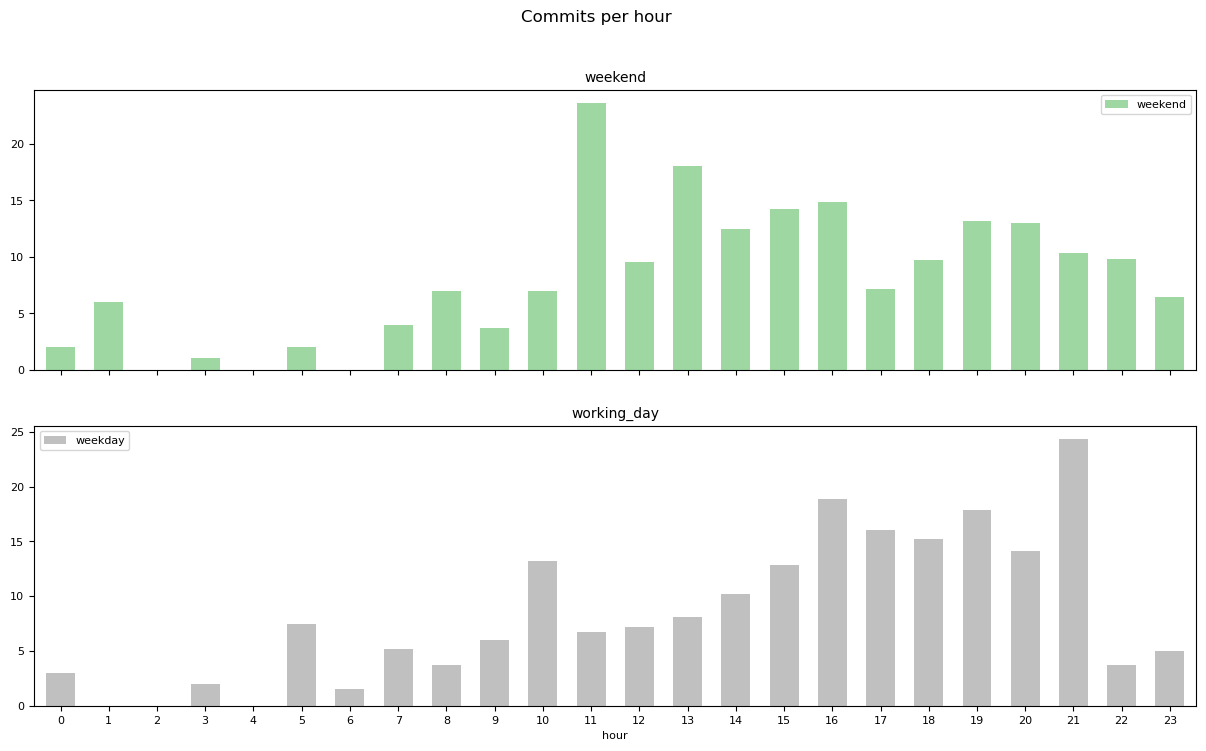

In [53]:
axes = avg_by_hour[['weekend', 'weekday']].plot(
    kind='bar',
    subplots=True,       
    layout=(2, 1),      
    figsize=(15, 8),
    title=['weekend', 'working_day'],
    color=['#9ED7A2', '#C0C0C0'],  
    fontsize=8,
    width=0.6,
    legend=False
)


ax1, ax2 = axes[0, 0], axes[1, 0]

for ax, title in zip([ax1, ax2], ['weekend', 'working_day']):
    ax.set_title(title, fontsize=10)
    ax.tick_params(axis='x', rotation=0, labelsize=8)
ax1.legend(fontsize=8, title_fontsize=8, loc='upper right')
ax2.legend(fontsize=8, title_fontsize=8, loc='upper left')
ax2.set_xlabel("hour", fontsize=8)
ax1.figure.suptitle('Commits per hour', fontsize=12)

Закрываем соединение с базой данных

In [54]:
connection.close()

Отличается ли динамика в рабочие и выходные дни?

Ответ: в рабочий дернь наибольшее число коммитов: `21`, в выходной день : `11`